## About the dataset

The dataset is a HR dataset sourced from Kaggle using a kaggle API and contains employee data for 14,249 employees with various metrics about each employee. The dataset will be used to predict if an employee is going to resign by understanding what role the features play as indicators of employee churn. 

This is a classification problem where the label is a binary variable - 1 for employees that left, and 0 for current employees. 
Target variable Y, is the probability of an employee leaving the company.

## Import Libraries

In [7]:
# importing libraries for data handling and analysis
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook # open MS Excel workooks - good to have
import numpy as np
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
import statistics
import warnings
warnings.filterwarnings('ignore')

In [8]:
# importing libraries for data visualisations
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')
from IPython.display import display
pd.options.display.max_columns = None

# ensures plots by default have a certain size and font size
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from IPython.display import display
pd.options.display.max_columns = None
# Standard plotly imports
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
cf.go_offline()

In [67]:
# sklearn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# import scalers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# sklearn modules for ML model selection
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Libraries for data modelling
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Common sklearn Model Helpers
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.utils import class_weight

# PCA Library
from sklearn.decomposition import PCA

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

In [131]:
# importing misceallenous libraries
import os
import sys
import pickle
import time
import joblib

## Exploratory Data Analysis

### Import Data and Data Dictionary

In [5]:
# Read in cvs file
data = pd.read_csv("employee_data.csv")

# Check the size of the dataframe
print("Shape of dataframe is: {}".format(data.shape))

Shape of dataframe is: (14249, 10)


In [6]:
# Make a copy of the original dataset
df = data.copy()

In [7]:
# Read in the data dictionary describing the feature columns
pd.set_option('display.max_colwidth', None)
data_dict = pd.read_csv("data_dict.csv")

### Overview of Data

In [8]:
data_dict

,Heading,Description
0,status,Current employment status (Employed / Left)
1,department,Department employees belong(ed) to
2,salary,Salary level relative to rest of their department
3,tenure,Number of years at the company
4,recently_promoted,Was the employee promoted in the last 3 years?
5,n_projects,Number of projects employee is staffed on
6,avg_monthly_hrs,Average number of hours worked per month
7,satisfaction,Score for employee’s satisfaction with the company (higher is better)
8,last_evaluation,Score for most recent evaluation of employee (higher is better)
9,filed_complaint,Has the employee filed a formal complaint in the last 3 years?


In [9]:
# Dataset columns
df.columns

Index(['avg_monthly_hrs', 'department', 'filed_complaint', 'last_evaluation',
       'n_projects', 'recently_promoted', 'salary', 'satisfaction', 'status',
       'tenure'],
      dtype='object')

In [10]:
# Dataset header
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


> The dataset contains 7 numerical columns and 3 categorical columns providing information on the employees working history and employment details.

In [11]:
# Columns datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.1+ MB


In [12]:
# separating the columns by their type
df.columns.to_series().groupby(df.dtypes).groups

{int64: ['avg_monthly_hrs', 'n_projects'], float64: ['filed_complaint', 'last_evaluation', 'recently_promoted', 'satisfaction', 'tenure'], object: ['department', 'salary', 'status']}

> The data contains missing values in 6 of the columns. I will not expect employee data to be missing. I expect the human resources department has this information but not in a form that they have been able to convert the documentation into a usable form.

### Exploring the Numerical Features

In [13]:
# determine numerical features based on the number of unique values
df.select_dtypes(include='number').nunique()

avg_monthly_hrs        249
filed_complaint          1
last_evaluation      12359
n_projects               7
recently_promoted        1
satisfaction         13710
tenure                   8
dtype: int64

In [14]:
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


>'filed_complaint' and 'recently_promoted' have standard deviation of 0. These are likely indicator variables

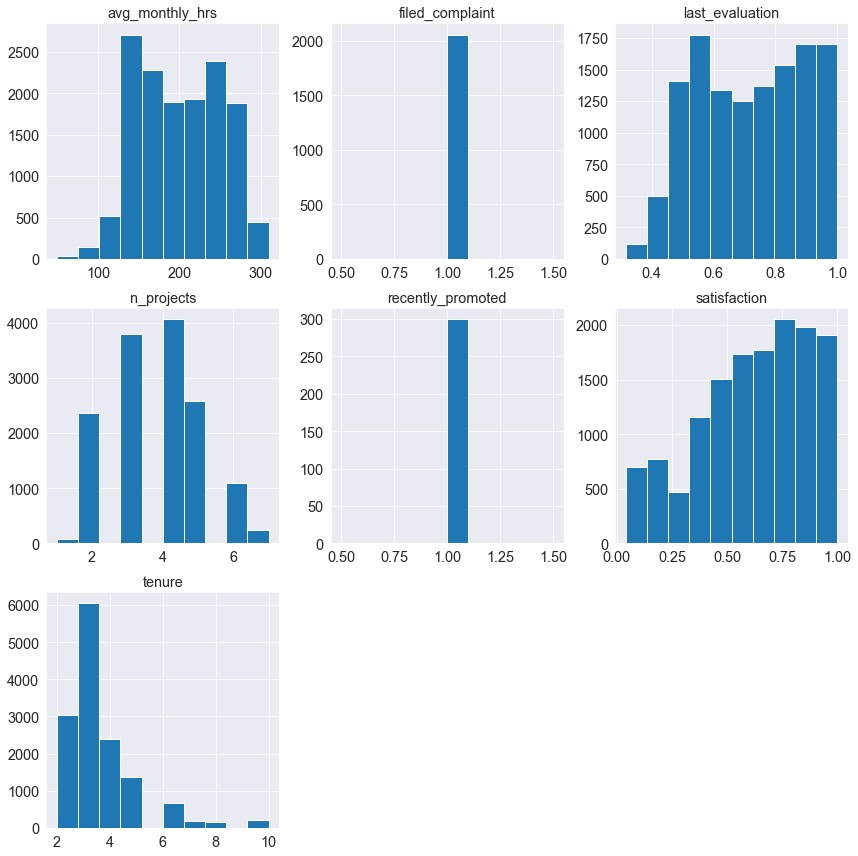

In [15]:
# Distribution of the numerical features
data.hist(figsize=(12,12))
plt.tight_layout()
plt.title('Distribution of the numerical features')
plt.show()

>Observations made based on the histogram and statistical description:
>
>- Filed_compliant and Recently_promoted have a standard deviation of '0' and likely to be binary indicator variables.
>- Several of the histograms are tail heavy:- Satisfaction and Last_evaluation are left skewed. Data transformation methods may be required to approach a normal distribution prior to fitting a model to the data.
>- Tenure and N_projects are right skewed with majority of employees being with the company for about 5 years or less and working on an average of 4 projects at any time.

#### Feature Analysis by 'status'

##### n_projects

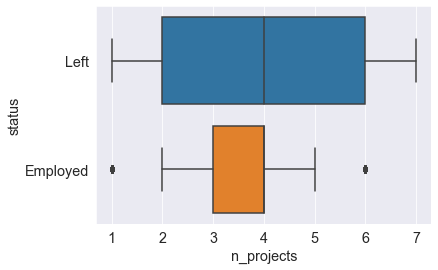

In [16]:
sns.boxplot(data=df,y='status',x='n_projects')
plt.savefig('Boxplot - Distribution of Number of Projects')
plt.show()

# sns.boxplot(y='status', x='satisfaction', data=df)
# plt.title('Distribution of Job Satisfaction')
# plt.show()

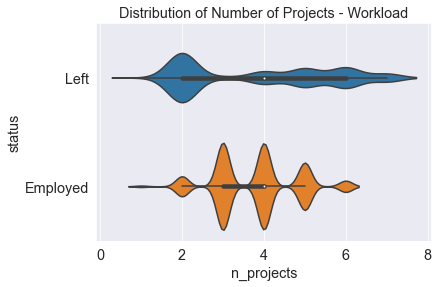

In [17]:
sns.violinplot(y='status', x='n_projects', data=df)
plt.savefig('Distribution of Number of Projects')
plt.title('Distribution of Number of Projects - Workload')
plt.show()

>Clustered distribution. Median number of projects for both left and employed is 4 projects. The areas of higher kernel density represent a higher probability of observations taken at 3 and 4 n_projects and the thinner sections corresponds to lower probability of observations of n_projects.  
>A high proportion of employees who left had lower workloads. 

##### Tenure

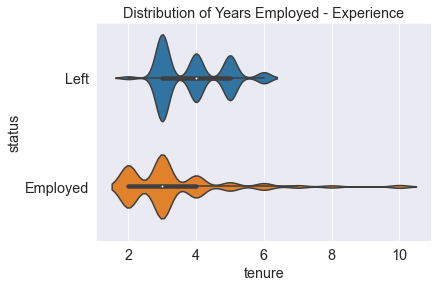

In [18]:
sns.violinplot(y='status', x='tenure', data=df)
plt.savefig('Distribution of Years Employed')
plt.title('Distribution of Years Employed - Experience')
plt.show()

>- Both Left and Employed display higher kernel density at the 3 years mark, which would indicate there was an large recruitment drive or a merger as there was an sharp increase in staff numbers at that time. High kernel density in year 2 would indicate another growth/expansion of the company.
>- Leavers have generally stayed with the company for longer. Median is 4 years. The higher kernel density at year 3 signifies a higher probability of observation implying a high number left at the 3 year mark.
>- Employed personnel have been with the company about 3 years (median). The longest serving employees have been there for over 10 years

##### Ave_monthly_hrs

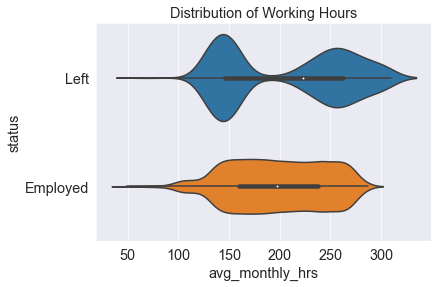

In [19]:
sns.violinplot(y='status', x='avg_monthly_hrs', data=df)
plt.savefig('Distribution of Working Hours')
plt.title('Distribution of Working Hours')
plt.show()

>- Among the employed staff, most people there is an equal distribution of people working from 150 - 270 hr/mth. Median average monthly hours is 200 hr/mth
>- Leavers worked either lesser hours or more than the median. Interestingly, the median number of hours for the leavers is 220 hrs/mth. Leavers were either overworked or unmotivated and worked contractual hours of 37.5 hrs/week.

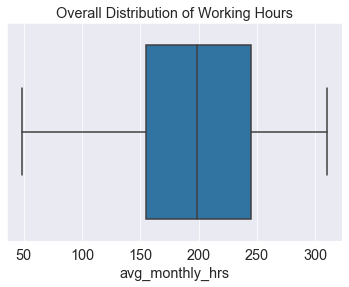

In [20]:
# Checking for outliers
x = df['avg_monthly_hrs']
sns.boxplot(x=x)
plt.title('Overall Distribution of Working Hours')
plt.show();

>- Leavers had worked either very short or very long hours.
>- There is a culture of working long hours (above the standard 37.5 hours/week).  50% of employees work more than the average of 200 hours a month.
>- Some employees worked much longer working hours (between 250 - 301 hours per month).

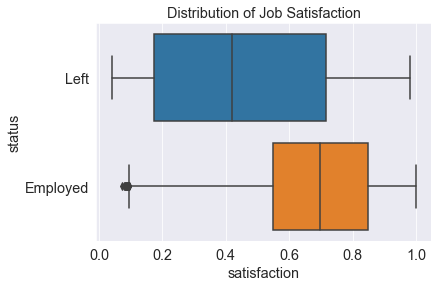

In [21]:
sns.boxplot(y='status', x='satisfaction', data=df)
plt.title('Distribution of Job Satisfaction')
plt.show()

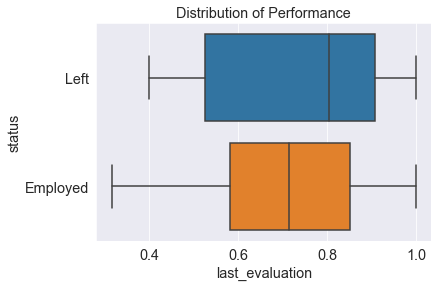

In [22]:
sns.boxplot(y='status', x='last_evaluation', data=df)
plt.title('Distribution of Performance')
plt.show()

Observations: 

>- Job satisfaction: current employees experience more job satisfaction than employees who left.
>- Work-life balance: Employees who left had worked longer hours than current employees.
>- Performance: Surprisingly, employees who left had higher evaluation scores. 
>- Experience: Employees who left has been with the company longer than current employees.

### Exploring the Categorical Features

#### Feature Analysis 

In [32]:
# Identify categorical features
df.describe(include=['object'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


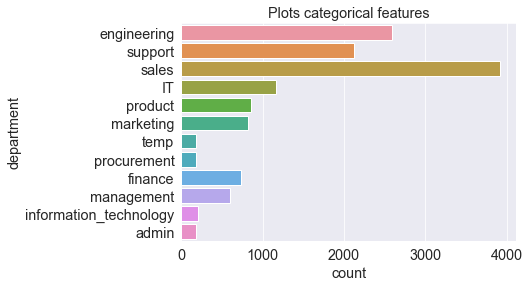

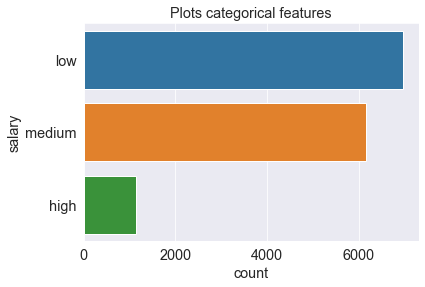

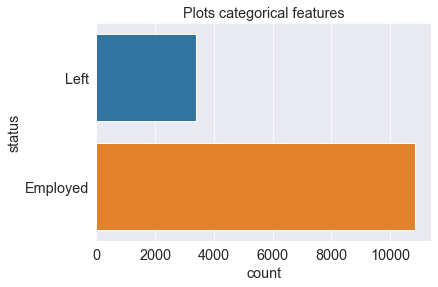

In [33]:
for feature in df.dtypes[df.dtypes=='object'].index:
    sns.countplot(y=feature, data=df)
    plt.title('Plots categorical features')
    plt.savefig('Plots categorical features')
    plt.show()

##### Department

In [34]:
df.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', nan, 'management',
       'information_technology', 'admin'], dtype=object)

In [35]:
df.groupby('department').mean().sort_values(by='avg_monthly_hrs', ascending=False)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
department,,,,,,,
engineering,202.469522,1.0,0.722332,3.872299,1.0,0.617907,3.402392
IT,202.175711,1.0,0.720712,3.806202,1.0,0.628324,3.481481
information_technology,202.167464,1.0,0.716156,3.832536,1.0,0.626717,3.315789
admin,201.272727,1.0,0.726282,3.897727,1.0,0.611450,3.369318
finance,201.175824,1.0,0.723880,3.815934,1.0,0.586787,3.543956
management,201.025210,1.0,0.729714,3.857143,1.0,0.630428,4.294118
support,200.975495,1.0,0.723200,3.804430,1.0,0.626923,3.394910
sales,200.842467,1.0,0.711254,3.772878,1.0,0.623075,3.527148
product,199.991860,1.0,0.719616,3.817442,NaN,0.628774,3.487209


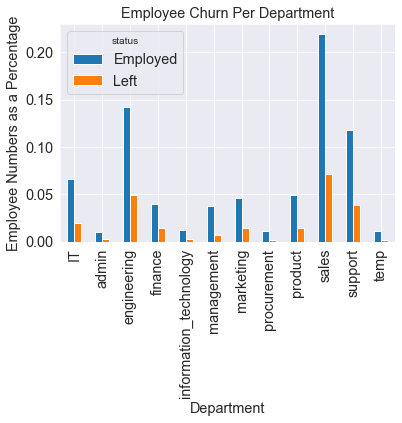

In [36]:
# Bar chart showing Employee churn per department
pd.crosstab(data['department'], df['status'], normalize='all').plot(kind='bar')
plt.title('Employee Churn - Per Department')
plt.xlabel('Department')
plt.ylabel('Employee Numbers as a Percentage')
plt.title('Employee Churn Per Department')
plt.savefig('Churn_bar_chart')

Observations made on the plots above:
>- IT and Information_technology are assumed to be the same departments and will be merged.
>- Temp department is not relevant as the objective is to model churn of permanent employees. These rows will be dropped from the dataset.
>- Nan is missing a department title.
>- Engineering and IT have the highest number of woking hours.
>- Sales had the highest churn, followed by Engineering and Support departments.

##### Salary

In [37]:
df.salary.value_counts()

low       6952
medium    6146
high      1151
Name: salary, dtype: int64

In [38]:
df.groupby('salary').mean()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
salary,,,,,,,
high,199.261512,1.0,0.706527,3.748914,1.0,0.647538,3.682137
low,200.015247,1.0,0.720202,3.773878,1.0,0.608019,3.434871
medium,199.647576,1.0,0.718740,3.778392,1.0,0.631412,3.533113


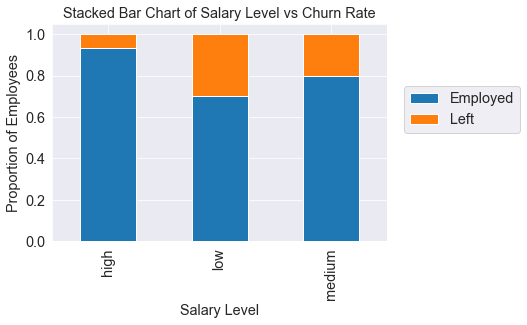

In [39]:
# Barchart for employee salary level and the churn rate
table=pd.crosstab(data['salary'], df['status'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Salary Level vs Churn Rate')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.legend(loc=(1.05,0.5))
plt.savefig('salary_bar_chart')

Observations made:

>- 48% of employees were on lower salaries compared to their colleagues in the same department.
>- 8% of employees earned salaries on the highest scale in comparison to others in their department. These are assued to be people in senior leadership positions.
>- Majority of employees who left were on a low salary scale compared to their coleagues.
>- lowest churn rate is among the 'high' salary scale.

##### Target Variable: Status

In [40]:
df['status'].value_counts()

Employed    10857
Left         3392
Name: status, dtype: int64

In [41]:
# Check the class baseline
print('Mode: ', statistics.mode(df.status)) # mode of the class
baseline = df['status'].value_counts()[0]/len(df['status'])
print(f'Baseline: {round(baseline * 100,0)}%')

Mode:  Employed
Baseline: 76.0%


In [42]:
df.groupby('status').mean()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
status,,,,,,,
Employed,197.700286,1.0,0.714479,3.755273,1.0,0.675979,3.380245
Left,206.502948,1.0,0.730706,3.833137,1.0,0.447500,3.869023


Observations made:

>- 3,392 employees left the company, which is 23.8% of the total employee population. 76.2% remain employed.
>- Slight class imbalance.
>- Average monthly hours of leavers is higher than that of the employees who stayed.
>- Average satisfaction level of current employees who stayed is higher than that of employees who left.
>- Tenure of the leavers was higher than that of those who remained - Longer serving employees are more likely to leave. 

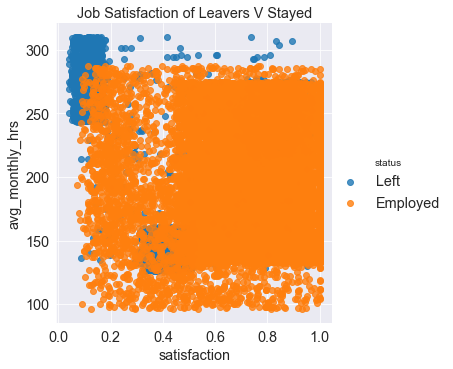

In [43]:
sns.lmplot(x='satisfaction', y='avg_monthly_hrs', hue='status', data=df, fit_reg=False)
plt.title('Job Satisfaction of Leavers V Stayed')
plt.show()

> The plot is messy and does not tell us much, however we can spot that there are distinct clusters. We will explore this further below

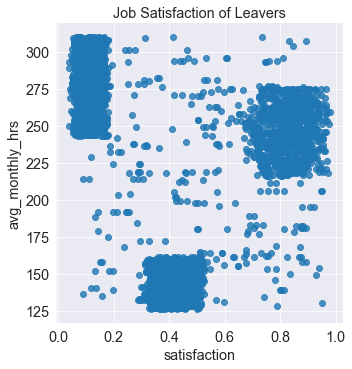

In [44]:
sns.lmplot(x='satisfaction', y='avg_monthly_hrs', data=df[df.status=='Left'],fit_reg=False)
plt.title('Job Satisfaction of Leavers')
plt.show()

>Observation: 3 distinct clusters
>- Satisfaction < 0.2 (Overworked) - Little job satisfaction & high workload. 
>- Av_monthly_hrs < 160hrs (Unmotivated) - Moderately happy & low workload.
>- Satisfaction > 0.7 (Workaholics) - high job satisfaction & high workload.
>
>We define new features: "Workaholics", "unmotivated" and "Overworked" by the following logic:
>- Workaholics: avg_monthly_hrs > 210 and satisfation > 0.7
>- Unmotivated: avg_monthly_hrs < 170
>- Overworked: avg_monthly_hrs > 225 and satisfaction < 0.2

In [122]:
df['workaholic'] = ((df.avg_monthly_hrs > 210) & (df.satisfaction > 0.7)).astype(int)
df['unmotivated'] = (df.avg_monthly_hrs < 170).astype(int)
df['overworked'] = ((df.avg_monthly_hrs > 225) & (df.satisfaction < 0.2)).astype(int)

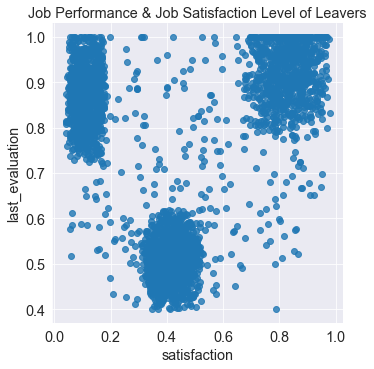

In [45]:
sns.lmplot(x='satisfaction', y='last_evaluation', data=df[df.status=='Left'], fit_reg=False)
plt.title('Job Performance & Job Satisfaction Level of Leavers')
plt.show()

>Observation: 3 distinct clusters
>
>- Satisfaction < 0.2 (unhappy) - low job satisfaction & performing well. Competent at their job but perhaps overqualified and not feeling challenged by the work?
>- Last_evaluation < 0.6 (under-performers) - low performance & low job satisfaction. Perhaps under-qualified?
>- Satisfaction > 0.7 (overachievers) - high job satisfaction & performance.
>
>Comments: There are some 0's for last_evaluation which came from the data cleaning steps. Note that we are not including them in the modeling via. the df.last_evaluation_missing==0" condition. We define new features: "Under-performers", "Unhappy" & "Overachievers" by the following logic:
>
>- Under-performers: for last_evaluation < 0.6
>- Unhappy: satisfaction_level < 0.2 (maybe these employees were overqualified and bored?)
>- Overachievers: last_evaluation > 0.8 and satisfaction > 0.7

In [120]:
df['underperformer'] = ((df.last_evaluation < 0.6) & (df.last_eval_missing==0)).astype(int)
df['unhappy'] = (df.satisfaction < 0.2).astype(int)
df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

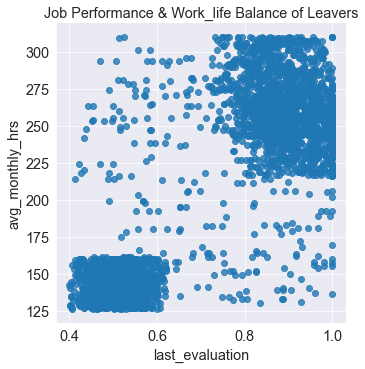

In [46]:
sns.lmplot(x='last_evaluation', y='avg_monthly_hrs', data=df[df.status=='Left'], fit_reg=False)
plt.title('Job Performance & Work_life Balance of Leavers')
plt.show()

>Observation: 2 distinct clusters
>- Av_monthly_hrs < 160, last evaluation < 0.6 (bad hires) - low performance & workload
>- Last evaluation >0.8 (stars) - those who had high performace scores and also worked longer hours than most employees.
>
>comments: Similar to above, the last_evaluation==0 data came from data cleaning and will not be included in the modelling. We define new features: "Stars" & "bad hires" by the following logic:
>
>- Stars: avg_monthly_hrs > 215 and last_evaluation > 0.75
>- bad hires: avg_monthly_hrs < 165 and last_evaluation < 0.65

In [121]:
df['star'] = ((df.avg_monthly_hrs > 215) & (df.last_evaluation > 0.75)).astype(int)
df['bad_hire'] = ((df.avg_monthly_hrs < 165) & (df.last_evaluation < 0.65) & (df.last_eval_missing==0)).astype(int)

In [123]:
# Let's see the proportion of employees in each of these groups:
df[['underperformer', 'unhappy', 'overachiever', 'star', 'bad_hire', 'workaholic', 'unmotivated', 'overworked']].mean().sort_values(ascending=False)

unmotivated       0.339281
underperformer    0.285257
star              0.241825
workaholic        0.226685
overachiever      0.177069
bad_hire          0.167686
unhappy           0.092195
overworked        0.071581
dtype: float64

> Highest group of leavers belong to the unmotivated cluster - <160hrs/mth and <0.5 satisfaction scores

### Data Pre-processing

In this section, we undertake data pre-processing steps to prepare the dataset for Machine Learning algorithm implementation.

In [47]:
# determine the missing values
df.isnull().sum()

avg_monthly_hrs          0
department             709
filed_complaint      12191
last_evaluation       1532
n_projects               0
recently_promoted    13949
salary                   0
satisfaction           181
status                   0
tenure                 181
dtype: int64

>6 features with missing values --department, filed_complaint, last_evaluation, recently_promoted, satisfaction and tenure

In [48]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.shape

(14221, 10)

In [49]:
# filed_complaint - change the NaNs to 0
df.filed_complaint.fillna(0, inplace=True)
df.filed_complaint.unique()

array([0., 1.])

In [50]:
# recently_promoted - change the NANs to 0
df.recently_promoted.fillna(0, inplace=True)
df.recently_promoted.unique()

array([0., 1.])

In [51]:
# re-check missing values
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1504
n_projects              0
recently_promoted       0
salary                  0
satisfaction          153
status                  0
tenure                153
dtype: int64

In [52]:
# combine IT and information_technology 
df.department.replace('information_technology', 'IT', inplace=True)

In [53]:
# drop the 'temp' (temporary workers) class from department feature:
df = df[df.department != 'temp']

In [54]:
df.shape

(14068, 10)

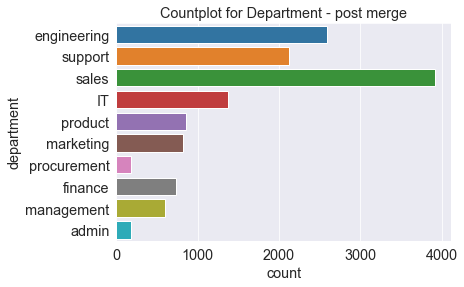

In [55]:
# Plot class distributions for department
sns.countplot(y='department', data=df)
plt.title('Countplot for Department - post merge')
plt.show()

In [56]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

>- Satisfaction and tenure no longer have missing figures. They must have all belonged to the temp class.
>- Last_evaluation: There are 1,351 missing values in last_evaluation, accounting for approx 10% of the datset. These could represent employees who performed poorly and could have an impact on the model. As a result, it is prudent not to remove the rows but to create a new column to indicate the missing values as 1 (binary) and analyse the impact.

In [57]:
# rename department with missing value
df['department'].fillna('unknown', inplace=True)

In [58]:
# create a new feature to indicate the missing last_evaluation scores 
df['last_eval_missing'] = df.last_evaluation.isnull().astype(int)

In [59]:
# fill in the missing values with 0
df.last_evaluation.fillna(0, inplace=True)

In [60]:
# confirm there are no more missing values to fill in
df.isnull().sum()

avg_monthly_hrs      0
department           0
filed_complaint      0
last_evaluation      0
n_projects           0
recently_promoted    0
salary               0
satisfaction         0
status               0
tenure               0
last_eval_missing    0
dtype: int64

#### Correlation of Linear Coefficients

In [61]:
df['Leavers'] = df['status'].map({'Left':1, 'Employed':0})
df['Leavers'].value_counts()

0    10701
1     3367
Name: Leavers, dtype: int64

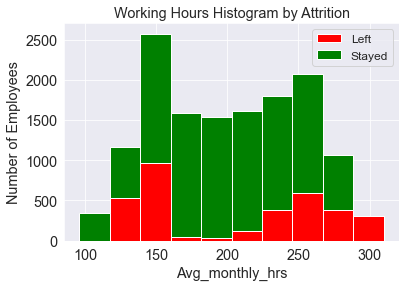

In [62]:
plt.hist(x=[df[df['Leavers']==1]['avg_monthly_hrs'], df[df['Leavers']==0]['avg_monthly_hrs']], stacked=True, color = ['r', 'g'], label = ['Left', 'Stayed'])
plt.title('Working Hours Histogram by Attrition')
plt.xlabel('Avg_monthly_hrs')
plt.ylabel('Number of Employees')
plt.legend(loc=1, prop={'size': 12})
plt.savefig("Working hours by Attrition")
plt.show();

In [63]:
df.corr()['Leavers'].sort_values(ascending=False)

Leavers              1.000000
tenure               0.142759
avg_monthly_hrs      0.069282
last_evaluation      0.063693
n_projects           0.021283
last_eval_missing   -0.050518
recently_promoted   -0.062043
filed_complaint     -0.156927
satisfaction        -0.389232
Name: Leavers, dtype: float64

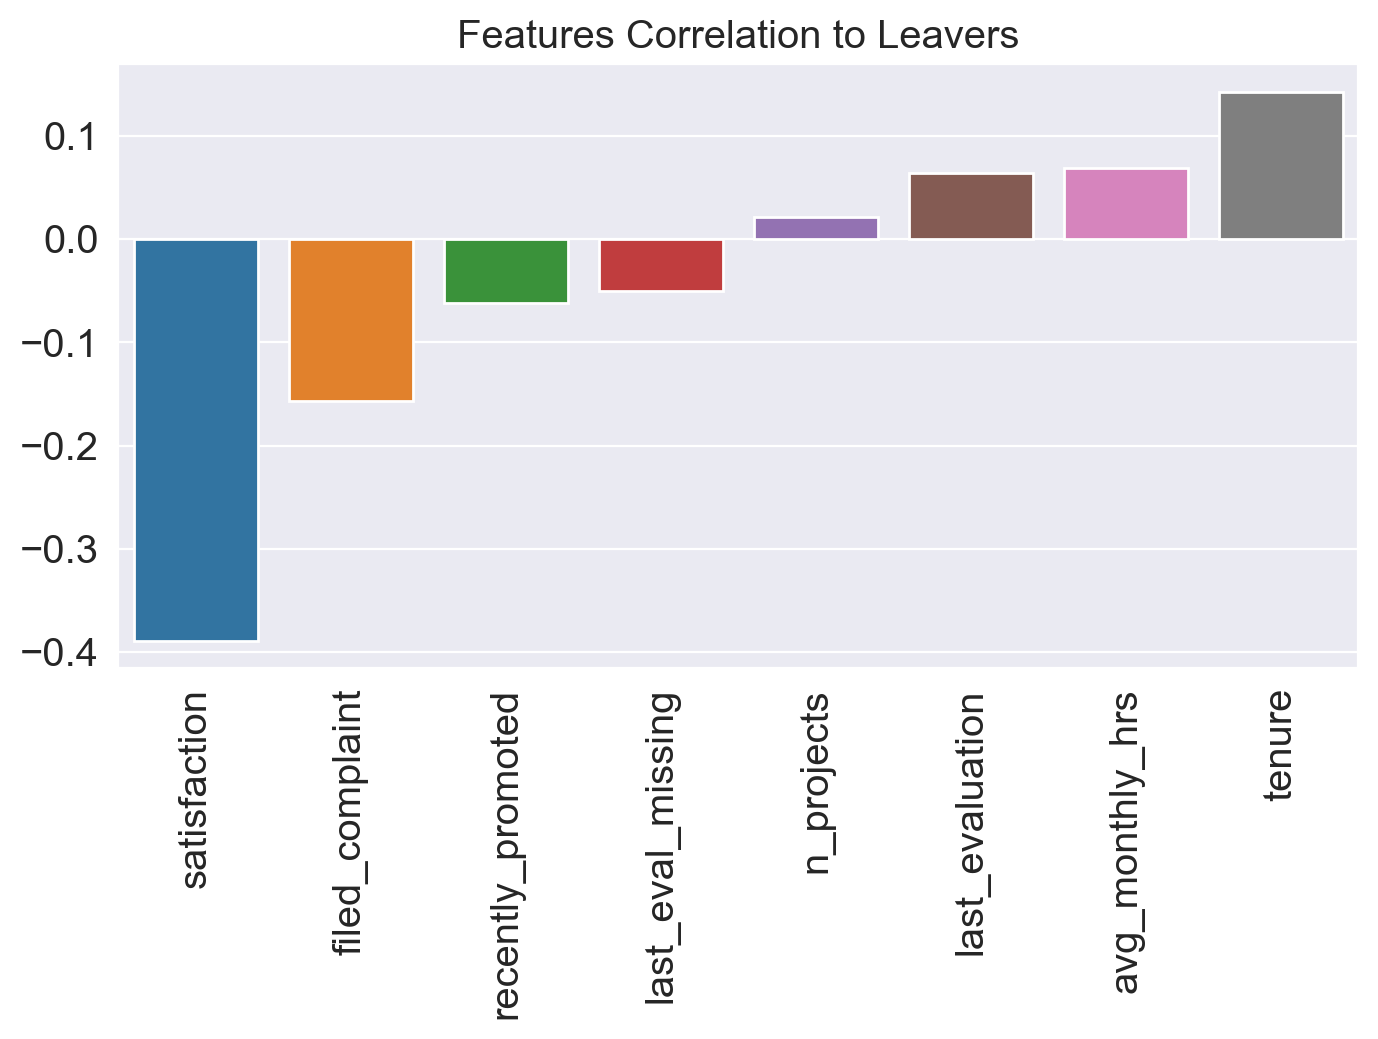

In [64]:
plt.figure(figsize=(8,4),dpi=200)
sns.barplot(x=df.corr()['Leavers'].sort_values().iloc[:-1].index,y=df.corr()['Leavers'].sort_values().iloc[:-1].values)
plt.title("Features Correlation to Leavers")
plt.savefig("Features Correlated to Leavers barplot")
plt.xticks(rotation=90);

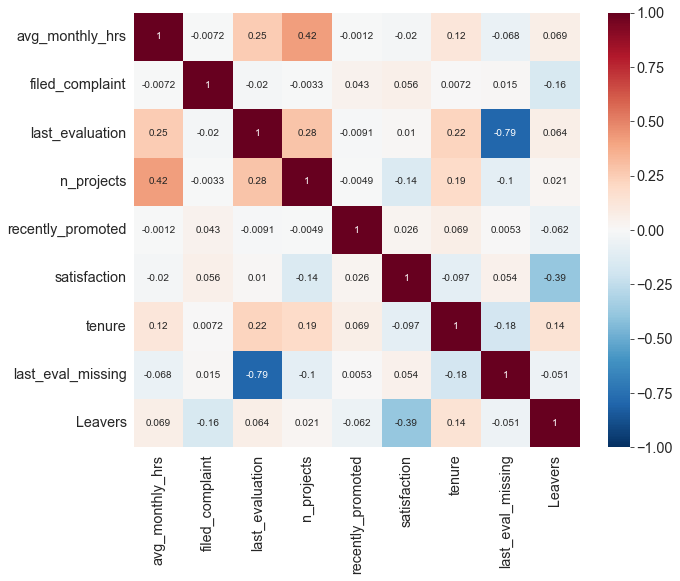

In [65]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.savefig('Correlation ')
plt.show()

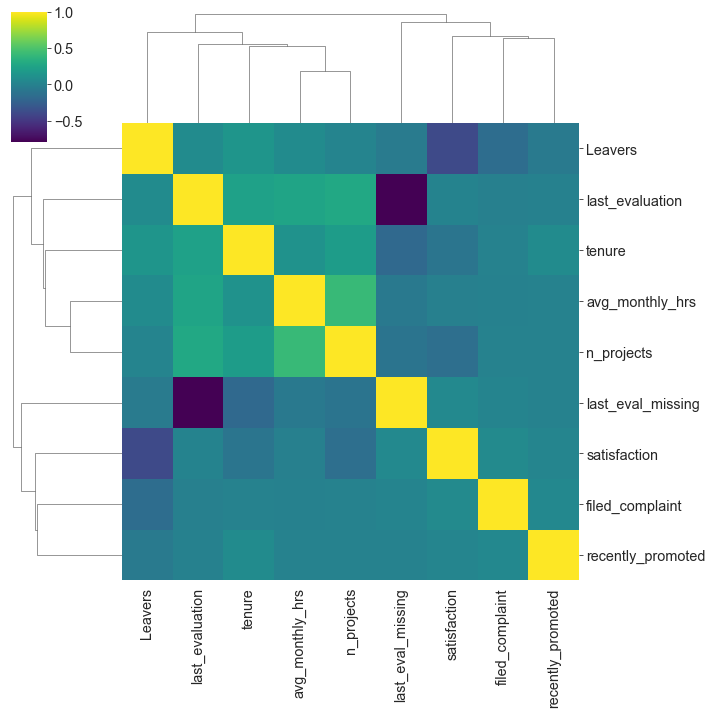

In [66]:
# clustermap with seaborn to explore the relationships between variables

sns.clustermap(df.corr(),cmap='viridis')
plt.savefig('Leavers correlation clustermap')
plt.show();

> With the correlation coefficients obtained, we can drop the Leavers column and convert the target variable into a binary indicator variable

In [67]:
df.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'procurement', 'finance', 'unknown', 'management', 'admin'],
      dtype=object)

In [68]:
# Drop Leavers column
df = df.drop(['Leavers'], axis=1)

#### Convert status into a dummy variable for the algorithms

In [69]:
df['status'] = pd.get_dummies(data.status).Left

In [70]:
df['status'].mean()

0.23933750355416547

> Percentage of employees that left - matches the calculation worked out above

In [71]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,last_eval_missing
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,1,5.0,0
1,232,support,0.0,0.000000,3,0.0,low,0.834544,0,2.0,1
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,0,3.0,0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,0,2.0,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,0,3.0,0


>- 'Left' is equal to 1
>- 'Employed' is equal to 0

#### Create dummy variables for the categorical variables using One-hot encoding:

In [72]:
df = pd.get_dummies(df, columns=['department', 'salary'])

In [73]:
df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_eval_missing,department_IT,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,department_unknown,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [74]:
df.shape

(14068, 23)

### EDA Findings

>- The dataset contained missing values. Using data pre-processing methods, we were able to manipulate and clean the data in order to get it into a format that would be suitable to model. In addition, some interesting observations were made about our dataset during the analysis process:
>- There were 10 unique features, including our target variable, status.
>- The strongest positive correlation with the target feature is tenure at 14%.
>- The strongest negative correlation with the target feature is job satisfaction at -38.9% 
>- There is some imbalance of the dataset with 72% of the describing currently employed people, which is as expected.
>- Group clusters based on the feature columns and characterising employee personalities were identified.
We will call these risk catergories and could be used to fine tune our model if required. However, the main object of these categorization would be to formulate a strategy/policy to handle retention:
>> - Overworked
>> - Unmotivated
>> - Workaholics
>> - Demotivated
>> - Underperformers
>> - Overachievers
>> - Stars
>> - Bad hires

>In addition, the following observation were made:
>- The highest proportion of leavers worked less hours than employees who stayed and well below company average.
>- The highest proportion of leavers were in the low salary band.
>- The highest proportion of leavers were sales representatives, followed by engineers and support (customer facing departments).
>- The highest proportion of leavers scored higher in their evaluation than those who stayed. Perhaps they were over qualified.
>- The highest proportion of leavers stayed on average for 4 years before moving on.

### Save the clean dataset to CSV

In [75]:
df.to_csv('clean_data.csv', index=None)

> The resulting dataframe has 23 columns 14,068 employees